### This notebook is used to preprocess both the audio and the transcription of our dataset

In [9]:
#import necessary libraries
import os
import pandas as pd
import librosa
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

### First Resample audio but maintain its original sample rate

In [2]:
#This is a function that defines the location of the original audio file (file_path)
#The path to save the processed audio file (output_path)
# The default target sample rate for TTS tasks 
def accurate_resample_audio(input_path, output_path, target_sr=16000):
    """
    input_path - audio_path : str
    output_path - resampled_audio path : str
    target_sr - target sample rate : int
    """
    try:
        # Load audio with its original sample rate, using soundfile for better preservation
        #read the audio file and its audio signal (i.e waveform) in y
        #it's original sample rate in orig_sr without changing it
        y, orig_sr = sf.read(input_path)
        
        # If stereo, convert to mono by averaging channels
        if y.ndim > 1:
            y = y.mean(axis=1)
        
        # High-quality resampling
        #make sure every audio signal have the same sample rate by resampling
        y_resampled = librosa.resample(
            y, 
            orig_sr=orig_sr, 
            target_sr=target_sr, 
            res_type='kaiser_best'  # High-quality resampling
        )
        
        # Write resampled audio to output path
        sf.write(output_path, y_resampled, target_sr)
        return True
    except Exception as e:
        print(f"Error resampling {input_path}: {e}")
        return False

### Now resample both audio and it's metadata (that contains it's transcript) using the resample function above

In [3]:
# 2. Batch Resampling Function
def batch_resample_and_update_metadata(base_dir, speakers, output_dir='resampled_audio', target_sr=16000):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare to collect all data
    all_data = []
    
   #go through each speaker in the list below
    for speaker in speakers:
        #join the folder directory with the speaker name in the list below
        speaker_output_dir = os.path.join(output_dir, speaker)
        os.makedirs(speaker_output_dir, exist_ok=True)
        
        # Original speaker directory
        speaker_dir = os.path.join(base_dir, speaker)
        
        # Load original transcript file
        #join the speaker directory with transcript file (tsv) to create a transcript directory 
        tsv_path = os.path.join(speaker_dir, 'recorder.tsv')
        
        #now load the tsv file
        try:
            # Read original metadata
            df = pd.read_csv(tsv_path, sep='\t', header=None)
            # Assign column names to the original metadata
            df.columns = ['audio_path', 'speaker_id', 'gender', 'category', 'transcription']
            
            # Prepare to track resampled audio paths
            resampled_paths = []
            
            # Resample each audio file in the metadata 
            #we want to make sure that the audio path to the speaker in the tsv file are standardized
            #meaning no matter how it's stored we can access the actual audio file
            #loop trough each row of the dataframe
            for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Resampling {speaker}"):
                # Get original audio filename in the column audio_path 
                audio_filename = os.path.basename(row['audio_path'])
                
                # Create full path to original audio
                #now create a proper full path to that audio file within the speaker directory
                original_audio_path = os.path.join(speaker_dir, audio_filename)
                
                # Create output path for resampled audio
                #this means that you are combining the base directory + speaker name + audio file name from metadata
                #for example : resampled_audio/pleshy_1/audio.wav
                output_audio_path = os.path.join(speaker_output_dir, audio_filename)
                
                # Resample audio using the resample function above
                #confirm if the method was successfully implemented then add the sampled audio path 
                #resample path list above 
                if accurate_resample_audio(original_audio_path, output_audio_path, target_sr):
                    resampled_paths.append(output_audio_path)

                #if error occurs add nothing to the list
                else:
                    resampled_paths.append(None)
            
            # create a new column in metadata dataframe then add all the audio path in the list (resampled_paths)
            # Update dataframe with new paths
            df['audio_path'] = resampled_paths
            #also do the same thing for speaker list (pleshy_1, pleshy_2)
            df['speaker_folder'] = speaker
            
            # Drop any rows with failed resampling
            df = df.dropna(subset=['audio_path'])
            
            # Collect data
            all_data.append(df)
        
        except Exception as e:
            print(f"Error processing {speaker}: {e}")
    
    # # combine all data in the all_data list
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Prepare final metadata for TTS training
    # Format the final metadata file with columns needed for TTS training
    final_df = pd.DataFrame({
        'audio_path': combined_df['audio_path'],
        'text': combined_df['transcription'],
        'speaker_id': combined_df['speaker_id']
    })
    
    # Save metadata
    final_df.to_csv('tts_metadata_16khz.csv', index=False)
    
    return final_df

In [6]:
# Usage Example
# Specify your base directory and speakers
base_dir = "/home/aljebra/text_to_speech/tts_data/tts_data"
speakers = ['pleshy_1', 'pleshy_3']

In [7]:
# Run the resampling and metadata update
metadata_df = batch_resample_and_update_metadata(base_dir, speakers)

Resampling pleshy_1:   0%|          | 0/250 [00:00<?, ?it/s]

Resampling pleshy_3: 100%|██████████| 250/250 [01:36<00:00,  2.59it/s]


### Visualize and listen to your processed audio 

In [16]:

def debug_audio_processing(original_path, resampled_path):
    # Load original audio
    y_orig, sr_orig = librosa.load(original_path, sr=None)
    
    # Load resampled audio
    y_proc, sr_proc = librosa.load(resampled_path, sr=None)
    
    # Print basic audio characteristics
    print("Original Audio:")
    print(f"Sample Rate: {sr_orig}")
    print(f"Duration: {len(y_orig)/sr_orig:.2f} seconds")
    print(f"Amplitude Range: [{y_orig.min()}, {y_orig.max()}]")
    
    print("\nResampled Audio:")
    print(f"Sample Rate: {sr_proc}")
    print(f"Duration: {len(y_proc)/sr_proc:.2f} seconds")
    print(f"Amplitude Range: [{y_proc.min()}, {y_proc.max()}]")
    
    # Visualize waveforms
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.title('Original Audio Waveform')
    plt.plot(y_orig)
    plt.subplot(2,1,2)
    plt.title('Resampled Audio Waveform')
    plt.plot(y_proc)
    plt.tight_layout()
    plt.show()
    
    # Spectral analysis
    D_orig = librosa.stft(y_orig)
    D_proc = librosa.stft(y_proc)
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.title('Original Audio Spectrogram')
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_orig), ref=np.max), 
                              sr=sr_orig, y_axis='hz', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(2,1,2)
    plt.title('Resampled Audio Spectrogram')
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_proc), ref=np.max), 
                              sr=sr_proc, y_axis='hz', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()



Original Audio:
Sample Rate: 48000
Duration: 4.63 seconds
Amplitude Range: [-0.99993896484375, 0.999908447265625]

Resampled Audio:
Sample Rate: 16000
Duration: 4.63 seconds
Amplitude Range: [-1.0, 0.999969482421875]


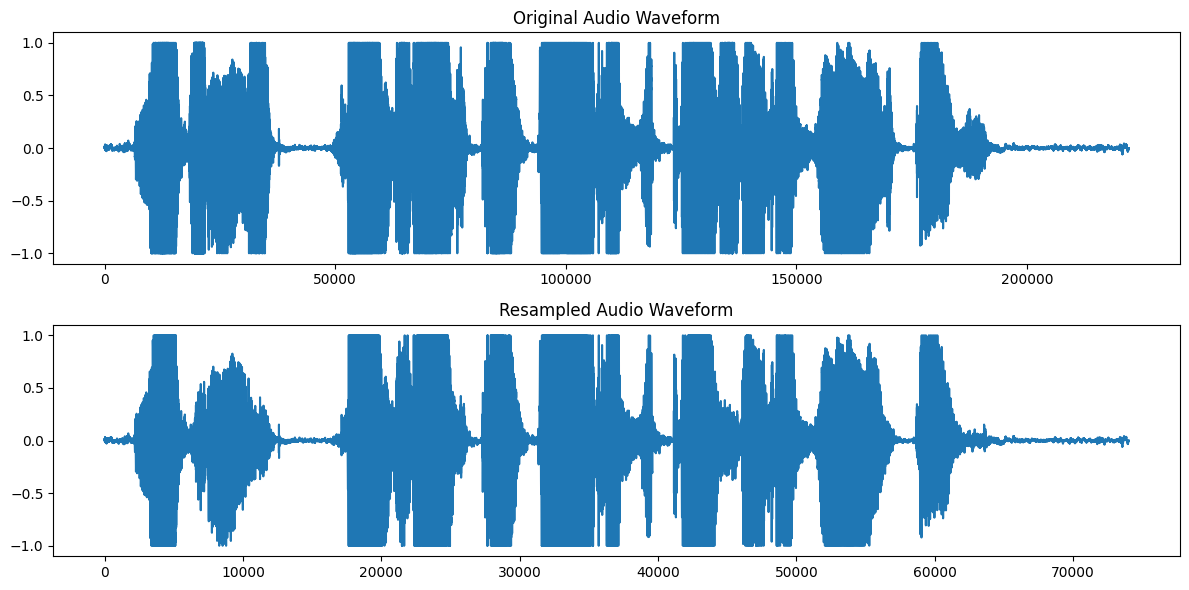

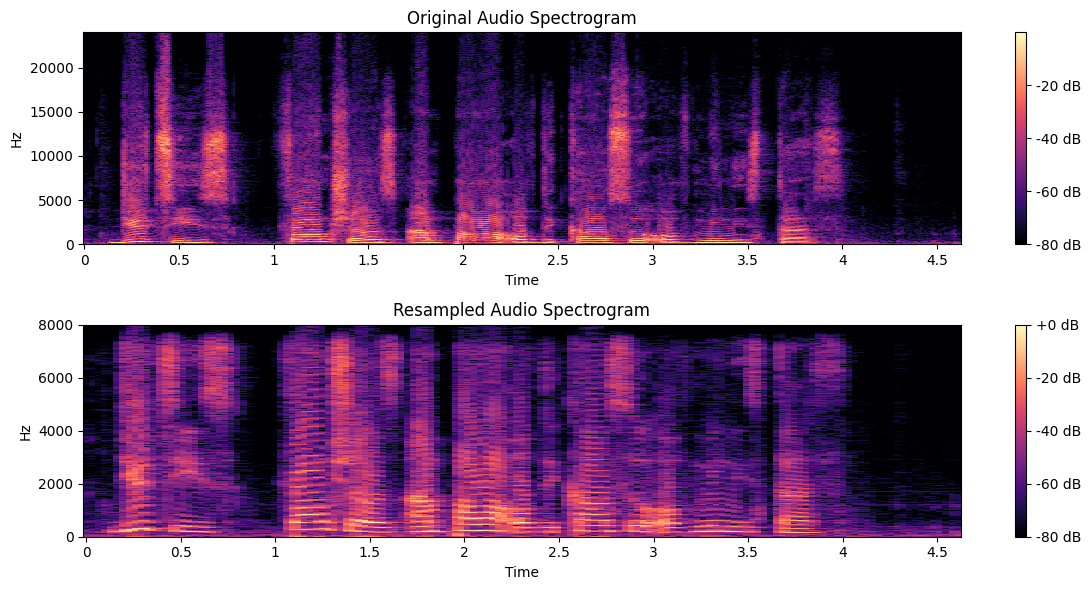

In [17]:
# Usage example
debug_audio_processing('tts_data/tts_data/pleshy_1/recorder_2024-04-11_13-38-52_009308.wav', 'resampled_audio/pleshy_1/recorder_2024-04-11_13-38-52_009308.wav')

In [24]:
#listen to the resampled audio
import sounddevice as sd
import soundfile as sf

def play_audio(file_path):
    # Read the audio file
    data, samplerate = sf.read(file_path)
    
    # Play the audio
    sd.play(data, samplerate)
    sd.wait()  # Wait until audio is finished playing

# Example usage
play_audio('/home/aljebra/text_to_speech/resampled_audio/pleshy_3/recorder_2024-04-15_13-14-59_243293.wav')